In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

## XGBoost for Nature + Kalman imputed dataset


In [3]:
X_train = read_csv('output/\CompleteDengueNatureKalmanTrain_0.csv')
X_test = read_csv('output/\CompleteDengueNatureKalmanTest_0.csv')

y = pd.read_csv('input/\dengue_labels_train.csv', parse_dates=True)

y = y.groupby(['year', 'weekofyear']).sum()
y_train = y.iloc[:734]
y_train = pd.DataFrame(index = X_train.index, data = y_train.total_cases.values)
y_test = y.iloc[734:]
y_test = pd.DataFrame(index = X_test.index, data = y_test.total_cases.values)


xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                  eval_metric = 'rmse',
                                  max_depth=3,
                                  n_estimators=360,
                                  learning_rate=0.001
                              )
model = xgb_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("\nRMSE: ", np.round(RMSE, 2))


RMSE:  27.93


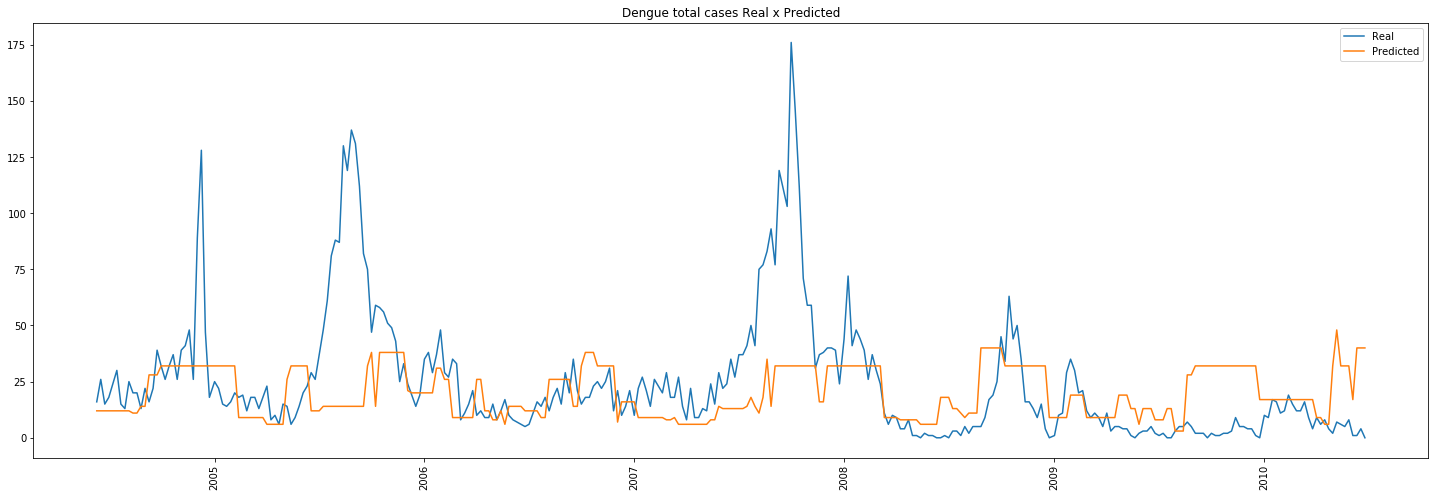

In [4]:
plt.figure(figsize=(25, 8))
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title("Dengue total cases Real x Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [5]:
def run_experiment_multiple_times(n=30):
    result_dict = {}
    result_dict= {'rmse':999999999999, 'best_model':None, 'best_rmse':999999999999}

    for i in range(0,n):
        y = pd.read_csv('input/\dengue_labels_train.csv', parse_dates=True)
        y = y.groupby(['year', 'weekofyear']).sum()
        X_train = read_csv('output/\CompleteDengueNatureKalmanTrain_'+str(i)+'.csv')
        X_test = read_csv('output/\CompleteDengueNatureKalmanTest_'+str(i)+'.csv')
        y_train = y.iloc[:734]
        y_train = pd.DataFrame(index = X_train.index, data = y_train.total_cases.values)
        y_test = y.iloc[734:]
        y_test = pd.DataFrame(index = X_test.index, data = y_test.total_cases.values)
        xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                      eval_metric = 'rmse',
                                      max_depth=3,
                                      n_estimators=360,
                                      learning_rate=0.001
                                      )
        model = xgb_model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        MSE = mse(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        
        print('Round', i, "rmse", RMSE)
        result_dict['rmse'] += RMSE
        if result_dict['best_rmse'] > RMSE:
            result_dict['best_rmse'] = RMSE
            result_dict['best_model'] = model

    result_dict['rmse'] = result_dict['rmse']/n
    return result_dict     

In [6]:
result_dict = run_experiment_multiple_times(n=30)

Round 0 rmse 27.929730418853694
Round 1 rmse 27.570515652293
Round 2 rmse 28.273494233831023
Round 3 rmse 28.962921013785774
Round 4 rmse 28.291678062975475
Round 5 rmse 28.363681226145747
Round 6 rmse 27.919441937389042
Round 7 rmse 28.515492864990662
Round 8 rmse 27.932060432413504
Round 9 rmse 28.692623906967217
Round 10 rmse 29.79629251465772
Round 11 rmse 28.284439605718262
Round 12 rmse 28.89603696670103
Round 13 rmse 29.130739777767403
Round 14 rmse 28.657639774767173
Round 15 rmse 28.809720581775867
Round 16 rmse 28.92370917397961
Round 17 rmse 28.89697078648419
Round 18 rmse 29.423023055326684
Round 19 rmse 28.08773103902547
Round 20 rmse 28.360826996695774
Round 21 rmse 28.769417183519117
Round 22 rmse 28.0587252649165
Round 23 rmse 28.36077102854105
Round 24 rmse 28.366926863559605
Round 25 rmse 27.901015513179207
Round 26 rmse 28.47594362052582
Round 27 rmse 28.498621520547772
Round 28 rmse 28.40098366282184
Round 29 rmse 28.60486139169521


In [7]:
result_dict

{'rmse': 33333333361.805187,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.001, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=360, n_jobs=0,
               num_parallel_tree=1, objective='multi:softprob', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'best_rmse': 27.570515652293}